<a href="https://colab.research.google.com/github/BlackberryBlues/2D_FEM_Heat/blob/main/Matus_Hancikovsky_STRAINS_Numerical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import gmsh
else:
    try:
        import gmsh
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
        import gmsh

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.tri as tri
from matplotlib.colors import LinearSegmentedColormap
import gmsh
import seaborn as sns
import time
from sympy import symbols, diff

In [32]:
# Initialize Gmsh
gmsh.initialize()

# Create a new model
gmsh.model.add("solar_panel")

# Define points at the boundary of the element
lc = 0.005  # characteristic length (coarse mesh)
lc = 0.001  # characteristic length (fine mesh)
gmsh.model.geo.addPoint(0, 0, 0, 2*lc, 1)  # x, y, z, characteristic length, id
gmsh.model.geo.addPoint(0.1, 0, 0, 2*lc, 2)
gmsh.model.geo.addPoint(0.1, 0.04, 0, lc, 3)
gmsh.model.geo.addPoint(0.1, 0.05, 0, lc, 4)
gmsh.model.geo.addPoint(0.1, 0.06, 0, lc, 5)
gmsh.model.geo.addPoint(0.04, 0.06, 0, lc, 6)
gmsh.model.geo.addPoint(0.04, 0.05, 0, lc, 7)
gmsh.model.geo.addPoint(0.04, 0.04, 0, lc, 8)
gmsh.model.geo.addPoint(0, 0.06, 0, 2*lc, 9)

# Define lines
gmsh.model.geo.addLine(1, 2, 1)  # point1, point2, id
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(4, 3, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.addLine(6, 9, 6)
gmsh.model.geo.addLine(9, 1, 7)
gmsh.model.geo.addLine(3, 8, 8)
gmsh.model.geo.addLine(7, 4, 9)
gmsh.model.geo.addLine(7, 6, 10)
gmsh.model.geo.addLine(8, 7, 11)

# Define the loops and surfaces
# loopss need to be counter-clockwise ccw
gmsh.model.geo.addCurveLoop([1, 2, 8, 11, 10, 6, 7], 1)
gmsh.model.geo.addCurveLoop([-8, -11, -9, -3], 2)
gmsh.model.geo.addCurveLoop([4, 5, -10, 9], 3)
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.addPlaneSurface([2], 2)
gmsh.model.geo.addPlaneSurface([3], 3)

# Synchronize the CAD kernel with the Gmsh model
gmsh.model.geo.synchronize()

# Define physical surfaces
gmsh.model.addPhysicalGroup(2, [1], 1)
gmsh.model.setPhysicalName(2, 1, "aluminium-frame")

gmsh.model.addPhysicalGroup(2, [2], 2)
gmsh.model.setPhysicalName(2, 2, "silicon-cell")

gmsh.model.addPhysicalGroup(2, [3], 3)
gmsh.model.setPhysicalName(2, 3, "glass-cover")

# Generate the mesh
gmsh.model.mesh.generate(2)

# Save and close
gmsh.write("solar_panel.msh")

gmsh.finalize()

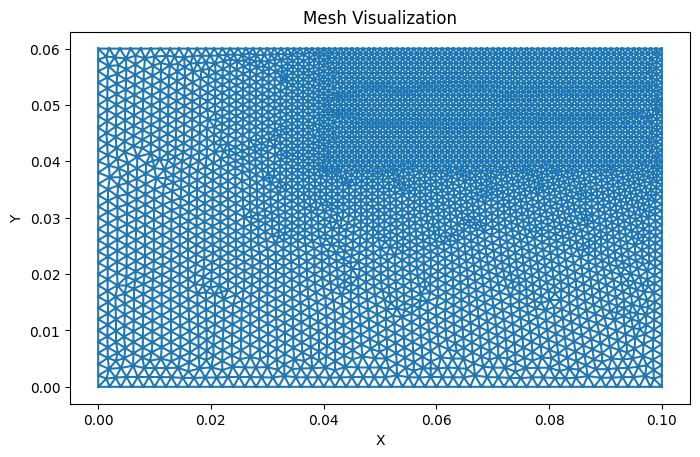

In [33]:
# Initialize Gmsh and load the mesh
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.open("solar_panel.msh")

# Get all nodes
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
node_coords = np.array(node_coords).reshape(-1, 3)  # node_coords in columns of x, y, z [:,0-1-2]

# Get all elements
element_types, element_tags, node_tags = gmsh.model.mesh.getElements()
node_tags = np.array(node_tags[0]).reshape(-1, 3)  # Assuming all elements are triangles

# Plot the mesh
plt.figure(figsize=(8, 8))
#plt.scatter(node_coords[:, 0], node_coords[:, 1])

# for i, (x, y) in enumerate(zip(node_coords[:, 0], node_coords[:, 1])):
#   plt.text(x, y, str(i))

plt.triplot(node_coords[:, 0], node_coords[:, 1], node_tags - 1)  # node_tags - 1 musi byt lebo inac by nesedeli cisla nodov v elemente
plt.gca().set_aspect('equal')
plt.title('Mesh Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Finalize Gmsh
gmsh.finalize()

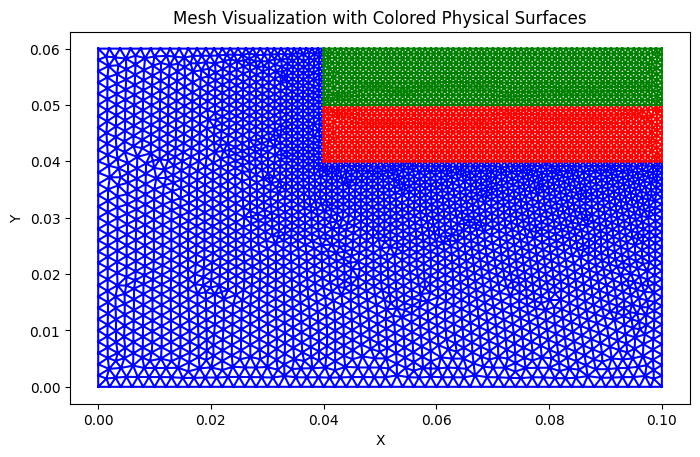

In [34]:
# Initialize Gmsh and load the mesh
gmsh.initialize()
gmsh.open("solar_panel.msh")

# Get all nodes
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
node_coords = np.array(node_coords).reshape(-1, 3)

# Function to get elements of a physical group
def get_elements_of_physical_group(dim, tag):
    entity_tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
    elements = []
    for entity_tag in entity_tags:
        element_types, element_tags, node_tags = gmsh.model.mesh.getElements(dim, entity_tag)
        for i in range(len(element_types)):
            elements.append(np.array(node_tags[i]).reshape(-1, 3))
    return np.concatenate(elements)

# Get elements for each physical surface
elements_surface_1 = get_elements_of_physical_group(2, 1)
elements_surface_2 = get_elements_of_physical_group(2, 2)
elements_surface_3 = get_elements_of_physical_group(2, 3)

surfaces = [elements_surface_1, elements_surface_2, elements_surface_3]  # create list of surfaces for easier iteration through them

# Plot the mesh
plt.figure(figsize=(8, 8))
plt.triplot(node_coords[:, 0], node_coords[:, 1], elements_surface_1 - 1, color='blue')
plt.triplot(node_coords[:, 0], node_coords[:, 1], elements_surface_2 - 1, color='red')
plt.triplot(node_coords[:, 0], node_coords[:, 1], elements_surface_3 - 1, color='green')
plt.gca().set_aspect('equal')
plt.title('Mesh Visualization with Colored Physical Surfaces')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Finalize Gmsh
gmsh.finalize()


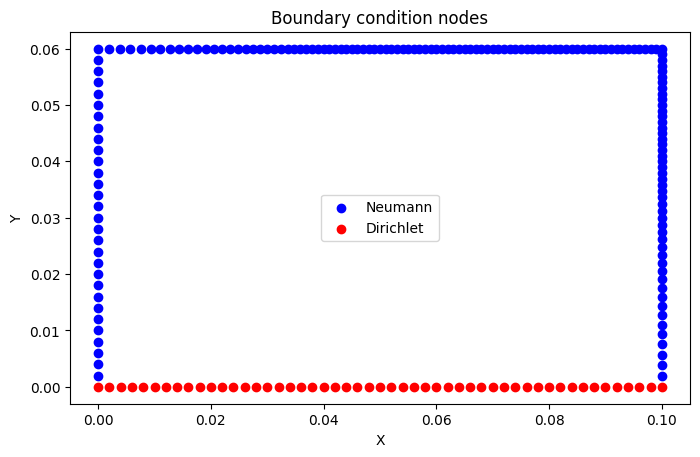

In [35]:
# Initialize Gmsh and load the mesh
gmsh.initialize()
gmsh.open("solar_panel.msh")

# Get all nodes
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
node_coords = np.array(node_coords).reshape(-1, 3)

# Set corner values of the studeid continuum
x_min = 0
x_max = 0.1
y_min = 0
y_max = 0.06

# Select only coordinates on the boundaries, without duplicate coordinates in the corners
left = node_coords[(node_coords[:,0] == x_min) & (node_coords[:,1] > y_min) & (node_coords[:,1] < y_max)]
right = node_coords[(node_coords[:,0] == x_max) & (node_coords[:,1] > y_min) & (node_coords[:,1] < y_max)]
bottom = node_coords[node_coords[:,1] == y_min]
top = node_coords[node_coords[:,1] == y_max]


# Plot the mesh
plt.figure(figsize=(8, 8))
plt.scatter(left[:, 0], left[:, 1], color='blue', label='Neumann')
plt.scatter(right[:, 0], right[:, 1], color='blue')
plt.scatter(top[:, 0], top[:, 1], color='blue')
plt.scatter(bottom[:, 0], bottom[:, 1], color='red', label='Dirichlet')
plt.gca().set_aspect('equal')
plt.title('Boundary condition nodes')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Finalize Gmsh
gmsh.finalize()

## Global scheme

Meshing ain't no FEM
 - node coordinates
 - node connectivity

1) Large system of equations, loop through the elements. For each element compyte elementary matrix [3x3] and elementary internal force vector [3x1]. In the mechanical part the sizes will be different.

2) Assemble the global stiffness matrix and right hand side vector, for the solution of the system (FEM for the purists)

3) Impose BCs (Difficult part)

4) Solve the system

5) Plot the results, postprocessing

In [36]:

  # s = integral (B_T * thermal condudtivity * B) d volume
  # B [2x3] ,B_T [3x2] - numerical integration
  # A*lambda*B_T*B (area*thermal conductivity*b transpose*b)

  # compute area
  # choose lambda
  # compute b = dependent on the node coordinates  DONE

  # Material, assign material tag DONE

  # p = integral (B_T * q) d volume
  # p = B_T * q * area; after numerical integration
  # q = thermal flux



In [37]:

# Calibration element
#node_coords = [[0, 0], [2, 0], [0, 1]]  # list of x,y coordinates of each element in the same order as test_elements
#test_elements = [[0, 1, 2]]  # list of element numbers


def N_tria(element):
  ''' calculates and returns matrix of symbolic shape functions N for tria element '''
  x, y = symbols('x y')  # to store shape functions symbolically

  # get coordinates of all element nodes
  x1 = node_coords[int(element[0] - 1)][0]  # - 1
  x2 = node_coords[int(element[1] - 1)][0]
  x3 = node_coords[int(element[2] - 1)][0]
  y1 = node_coords[int(element[0] - 1)][1]
  y2 = node_coords[int(element[1] - 1)][1]
  y3 = node_coords[int(element[2] - 1)][1]

  # b = np.array([[y2-y3, y3-y1, y1-y2], [x3-x2, x1-x3, x2-x1]])  # This is a condensed way of calculating B from nodal coordinates (don't quite understand how it was obtained)

  a1 = x2*y3 - x3*y2
  b1 = y2 - y3
  c1 = x3 - x2

  N1 = a1 + b1*x + c1*y  # shape function for node 1

  a2 = x3*y1 - x1*y3
  b2 = y3 - y1
  c2 = x1 - x3

  N2 = a2 + b2*x + c2*y  # shape function node 2

  a3 = x1*y2 - x2*y1
  b3 = y1 - y2
  c3 = x2 - x1

  N3 = a3 + b3*x + c3*y  # shape function node 3

  N = np.array([N1, N2, N3])  # save shape functions into array

  return N


def J(element):
  ''' returns determinant of jacobian (2x of tria element area) '''
  # not at all complicated way of computin jacobian
  # j = (x1-x3) * (coord(2,2)-coord(2,3)) - (coord(1,2) - coord(1,3)) * (coord(2,1) - coord(2,3)) ... and so on
  j = (node_coords[int(element[0]) - 1][0] - node_coords[int(element[2]) - 1][0]) * (node_coords[int(element[1]) - 1][1] - node_coords[int(element[2]) - 1][1] ) - (node_coords[int(element[1]) - 1][0] - node_coords[int(element[2]) - 1][0]) * ( node_coords[int(element[0]) - 1][1] - node_coords[int(element[2]) - 1][1])
  return j


def B(element):
  ''' strain-displacement matrix B by derivating N '''
  N = N_tria(element)  # call N_tria to get symbollical shape functions of element
  x, y = symbols('x y')  # to be able to symbollically differentiate
  Ndx = np.array([diff(n, x) for n in N])  # partial diff of each instance in shape function N wrt x
  Ndy = np.array([diff(n, y) for n in N])  # same but wrt y
  B = np.array([Ndx, Ndy]) / J(element) # SHOULD THERE BE 1/JACOBIAN HERE OR NOT...

  return B


def CST_thermal(K, F, element, material):
  ''' calculates and assembles global K and F and imposes BCs '''
  global left, right, bottom, top  # link global arrays of BCs nodes at eahc edge

  ''' K part '''
  B_matrix = B(element)  # calculate B matrix for the element [2x3]

  area = 0.5 * J(element)
  s = area * np.dot(np.dot(np.transpose(B_matrix), material), B_matrix) * 1 # compute the local stiffness of the element with the thickness 1 [3x3]

  #print(f's: \n {s}')

  np.add.at(K, (np.ix_(element - 1, element - 1)), s)  # populate global stiffness matrix with one line of code

  # for r, row in enumerate(s):
  #   for c, col in enumerate(row):
  #     if col != 0:
  #       K[int(element[r]) - 1, int(element[c]) - 1] += col  # add s matrix value to the global K at the right index if non-zero value

  ''' F part '''

  top_nodes = 0  # check value for number of nodes of element that are on the top layer

  p = np.zeros((3, 1))  # initiate p vector

  for i, node in enumerate(element):  # this will create RHS vector F

    x = node_coords[int(element[i]) - 1][0]  # get x of node
    y = node_coords[int(element[i]) - 1][1]  # get y of node (we only need to do this because of the way we stored the nodes on the boundaries)

    ''' Neumann '''
    if np.any((top[:, 0] == x) & (top[:, 1] == y)):  # if the node is on the top edge (Neumann sun flux)
      #print(f'Node {node} is in TOP bcs')
      if top_nodes == 0:  # finds one node on the top layer
        top_nodes += 1  # add to the counter
        first_node = node  # save this node number
        first_node_i = i  # save the node index
        continue
      elif top_nodes == 1:  # finds second node on the layer
        top_nodes = 0  # reset the top node counter

        x1 = node_coords[int(first_node) - 1][0]  # get x coord of frst node detected
        x2 = node_coords[int(node) - 1][0]  # get x coord of second node detected
        y_check = node_coords[int(node) - 1][1]  # unneccessary y coord check
        # print(f'Y check: {y_check}')
        # print(f'x1: {x1}, x2: {x2}')
        distance = np.absolute(x2 - x1)  # calculate x distance btwn top nodes
        # print(distance)

        q = 1000  # set the heat flux value [W / m]  <========================================================================= BC Neumann

        p[first_node_i] = q * distance / 2
        p[i] = q * distance / 2

        # write into the global right hand side vector F
        for r, row in enumerate(p):
          F[int(element[r]) - 1, 0] += row[0]  # row[0] just to get a value not list

        continue

      ''' Dirichlet '''
    elif np.any((bottom[:, 0] == x) & (bottom[:, 1] == y)):  # if the node is on the bottom edge (Dirichlet 0 temp)
      #print(f'Node {node} is in BOTTOM bcs')
      #K[row, all collumns] = identity  # row in the global stiffness to Identity row
      #F[node] = bc_temp  # nodal force to the prescribed value. Like this we get wanted temperature at given node
      identity_row = np.zeros((1, K.shape[0]))  # prepare row of zeros the same dimension as K
      identity_row[0, int(node) - 1] = 1  # place 1 at the index of the node
      K[int(node) - 1] = identity_row  # insert the identity row into the global matrix
      F[int(node) - 1] = 0  # prescribed nodal temperature  <=================================================================== BC Dirichlet
      continue
    else:  # otherwise continue with the loop
      #p = area * 0 * np.transpose(B_matrix)
      continue

    #print(f'p: \n {p}')



    top_nodes = 0


  return K, F


Quiestion)

p has shape 3x2. What shape should right hand side vector have if global matrix is 190x190 and how to populate F with values from p


K shape: (4125, 4125)
F shape: (4125, 1)


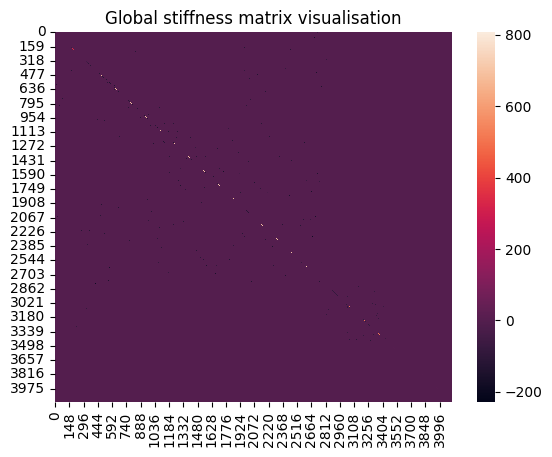

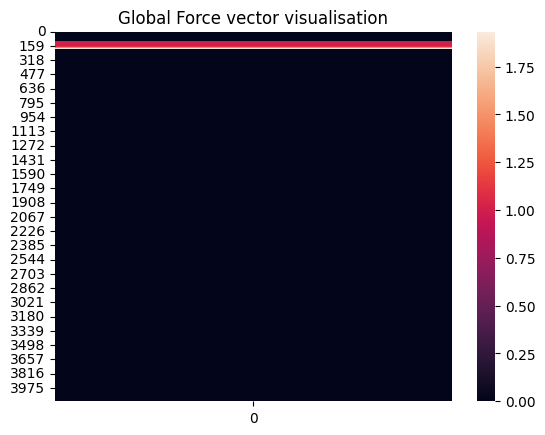

Number of non-zero elements in K: 28235
This took: 111.919084 precious seconds


In [38]:

# start time of the script
start_time = time.time()

mat = [200, 150, 1]  # thermal conductivity values for aluminum, silicon, glass [W*m-1*K-1]
#mat = {'al': 200, 'silicon': 150, 'glass': 1}

K = np.zeros((len(node_coords), len(node_coords)))
print(f'K shape: {K.shape}')  # shape of global K
F = np.zeros((len(node_coords), 1))
print(f'F shape: {F.shape}')
evolve = []


for s, surface in enumerate(surfaces):  # surfaces is list of 3 defined surfaces
  #print(f'Surface no: {s + 1}')
  for ss, element in enumerate(surface):  # surface is list consisting of elements defined by their node numbers [15 107 42]
    #print(f'Element no: {ss + 1} : {element}')
    K, F = CST_thermal(K, F, element, mat[s])


#x = np.arange(0,len(evolve),1)  # this plots the addition of terms into the K
#plt.plot(x, evolve)
#plt.title('Evolution of non-zero terms in K')
#plt.show()
sns.heatmap(K, annot=False, cmap='rocket')
plt.title('Global stiffness matrix visualisation')
plt.show()
sns.heatmap(F, annot=False, cmap='rocket')
plt.title('Global Force vector visualisation')
plt.show()
print(f'Number of non-zero elements in K: {np.count_nonzero(K)}')

# end time calculation
end_time = time.time()
elapsed_time = end_time - start_time
print(f"This took: {elapsed_time:.6f} precious seconds")

In [39]:
u = np.linalg.solve(K, F)  # solution of the linear system

print(u.shape)
np.savetxt('temperatures.csv', u, delimiter=',')  # save to a .csv file

(4125, 1)


Text(0.5, 0, '$T_{max}$ = 10.26 °C \t $T_{min}$ = -0.0 °C')

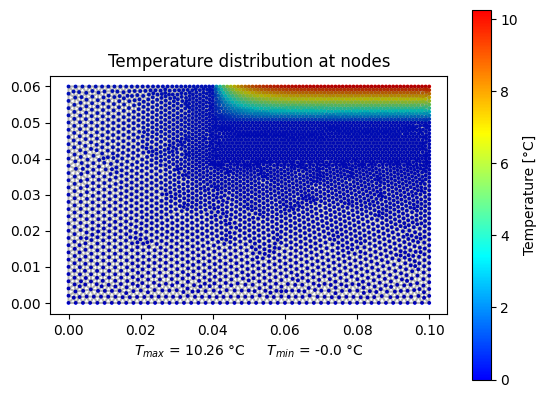

In [40]:
x = node_coords[:, 0]
y = node_coords[:, 1]

colors = ['blue','cyan', 'yellow', 'red']  # define custom colorbar colors
cmap1 = LinearSegmentedColormap.from_list('blue_to_red', colors)  # create colormap

plt.scatter(x,y, c=u[:, 0], s=3, cmap=cmap1)  # places colored circles on the nodes of the mesh

plt.triplot(x, y, alpha=0.3, color='k')  # underlaying mesh
plt.gca().set_aspect('equal')

plt.colorbar(label='Temperature [°C]')
plt.title('Temperature distribution at nodes')
plt.xlabel('$T_{max}$ = ' + str(round(max(u[:, 0]), 2)) + ' °C \t $T_{min}$ = ' + str(round(min(u[:, 0]), 2)) + ' °C' )

# Visible max and min temperature values. Glass heated up the most, keeping alu frame and silicon cells closely to the initial temperature


Text(0.5, 0, '$T_{max}$ = 10.26 °C \t $T_{min}$ = -0.0 °C')

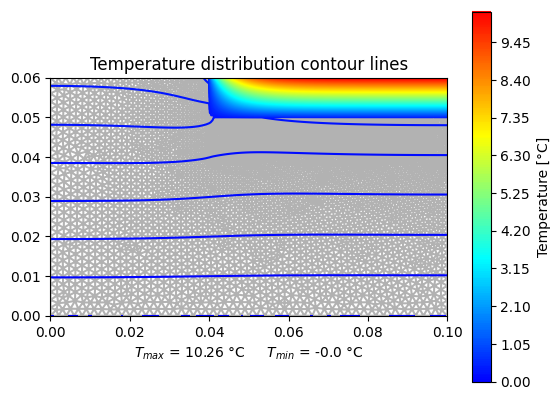

In [41]:
triang = Triangulation(x, y)

# Create a contour plot
plt.tricontour(triang, u[:, 0], levels=250, cmap=cmap1)  # because of large gradient in the glass, very little contour lines are visible in silicon and aluminum
plt.colorbar(label='Temperature [°C]')

plt.triplot(x, y, alpha=0.3, color='k')  # underlying mesh
plt.gca().set_aspect('equal')

plt.title('Temperature distribution contour lines')
plt.xlabel('$T_{max}$ = ' + str(round(max(u[:, 0]), 2)) + ' °C \t $T_{min}$ = ' + str(round(min(u[:, 0]), 2)) + ' °C' )


### Thermo-mechanical part


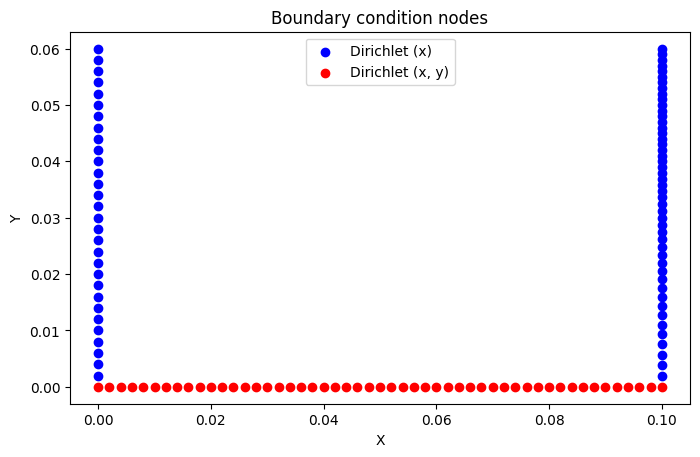

In [42]:
# Initialize Gmsh and load the mesh
gmsh.initialize()
gmsh.open("solar_panel.msh")

# Get all nodes
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
node_coords = np.array(node_coords).reshape(-1, 3)

# Set corner values of the studeid continuum
x_min = 0
x_max = 0.1
y_min = 0
y_max = 0.06

# Select only coordinates on the boundaries, without duplicate coordinates in the corners
left = node_coords[(node_coords[:,0] == x_min) & (node_coords[:,1] > y_min) & (node_coords[:,1] <= y_max)]  # Dirichlet fixed x (y more than 0 and less or equal than y_max value)
right = node_coords[(node_coords[:,0] == x_max) & (node_coords[:,1] > y_min) & (node_coords[:,1] <= y_max)]  # Dirichlet fixed x
bottom = node_coords[node_coords[:,1] == y_min]  # Dirichlet fixed in x and y


# Plot the mesh
plt.figure(figsize=(8, 8))
plt.scatter(left[:, 0], left[:, 1], color='blue', label='Dirichlet (x)')
plt.scatter(right[:, 0], right[:, 1], color='blue')
plt.scatter(bottom[:, 0], bottom[:, 1], color='red', label='Dirichlet (x, y)')
plt.gca().set_aspect('equal')
plt.title('Boundary condition nodes')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Finalize Gmsh
gmsh.finalize()

In [43]:
def N_tria(element):
  ''' calculates and returns matrix of symbolic shape functions N for tria element '''
  x, y = symbols('x y')  # to store shape functions symbolically

  # get coordinates of all element nodes
  x1 = node_coords[int(element[0] - 1)][0]  # - 1
  x2 = node_coords[int(element[1] - 1)][0]
  x3 = node_coords[int(element[2] - 1)][0]
  y1 = node_coords[int(element[0] - 1)][1]
  y2 = node_coords[int(element[1] - 1)][1]
  y3 = node_coords[int(element[2] - 1)][1]

  # b = np.array([[y2-y3, y3-y1, y1-y2], [x3-x2, x1-x3, x2-x1]])  # This is a condensed way of calculating B from nodal coordinates (don't quite understand how it was obtained)

  a1 = x2*y3 - x3*y2
  b1 = y2 - y3
  c1 = x3 - x2

  N1 = a1 + b1*x + c1*y  # shape function for node 1

  a2 = x3*y1 - x1*y3
  b2 = y3 - y1
  c2 = x1 - x3

  N2 = a2 + b2*x + c2*y  # shape function node 2

  a3 = x1*y2 - x2*y1
  b3 = y1 - y2
  c3 = x2 - x1

  N3 = a3 + b3*x + c3*y  # shape function node 3

  # N = np.array([[N1, 0, N2, 0, N3, 0], [0, N1, 0, N2, 0, N3], [N1, N1, N2, N2, N3, N3]])  # save shape functions into array, third row is to calculate B easily
  N = np.array([[N1, N2, N3, 0, 0, 0], [0, 0, 0, N1, N2, N3], [N1, N2, N3, N1, N2, N3]])  # alternate shape function matrix layout

  return N


def J(element):
  ''' returns determinant of jacobian (2x of tria element area) '''
  # not at all complicated way of computin jacobian
  # j = (x1-x3) * (coord(2,2)-coord(2,3)) - (coord(1,2) - coord(1,3)) * (coord(2,1) - coord(2,3)) ... and so on
  j = (node_coords[int(element[0]) - 1][0] - node_coords[int(element[2]) - 1][0]) * (node_coords[int(element[1]) - 1][1] - node_coords[int(element[2]) - 1][1] ) - (node_coords[int(element[1]) - 1][0] - node_coords[int(element[2]) - 1][0]) * ( node_coords[int(element[0]) - 1][1] - node_coords[int(element[2]) - 1][1])
  return j


def B(element):
  ''' strain-displacement matrix B by derivating N '''
  N = N_tria(element)  # call N_tria to get symbollical shape functions of element
  x, y = symbols('x y')  # to be able to symbollically differentiate
  Ndx = np.array([diff(n, x) for n in N[0]])  # partial diff of each instance in shape function N wrt x
  Ndy = np.array([diff(n, y) for n in N[1]])  # same but wrt y
  # Ndxdy = np.array([diff(n, y) if i % 2 == 0 else diff(n, x) for i, n in enumerate(N[2])])  # combined derivative dx dy for last row of N
  Ndxdy = np.array([diff(n, y) if i in [0, 1, 2] else diff(n, x) for i, n in enumerate(N[2])])  # alternate B matrix derivatives for last line

  B = np.array([Ndx, Ndy, Ndxdy]) / J(element) # SHOULD THERE BE 1/JACOBIAN HERE OR NOT... there should but I don't understand why

  return B


def C(E, nu):
  C = np.array([[1 - nu, nu, 0], [nu, 1 - nu, 0], [0, 0, (1 - 2*nu)/2]])
  C *= E/((1 + nu)*(1 - 2*nu))

  return C  # constitutive law relationship assuming plane strain



In [44]:
def CST_mechanical(K, F, element, E, nu, alpha):
  ''' calculates and assembles global K and F and imposes BCs '''
  global nodesn, u  # take global number of nodes and temperature/displacement field

  ui = element  # node index for u displacement
  vi = element + nodesn  # node index for v displacement (in the part of matrix shifted by number of nodes)
  # print(f'elements u: {ui}, index v: {vi}')

  element_index = np.concatenate((ui, vi), axis=0)  # combine new node indices for displacement [u1 u2 u3 v1 v2 v3]

  ''' K part '''
  B_matrix = B(element)
  C_matrix = C(E, nu)  # assuming plane strain
  area = 0.5 * J(element)

  k = area * np.dot(np.dot(np.transpose(B_matrix), C_matrix), B_matrix) * 1  # elementary stiffness matrix with thickness 1

  np.add.at(K, (np.ix_(element_index - 1, element_index - 1)), k)

  # for r, row in enumerate(k):
  #   for c, col in enumerate(row):
  #     if col != 0:
  #       K[int(element_index[r]) - 1, int(element_index[c]) - 1] += col  # add k matrix value to the global K at the right index if non-zero value

  ''' F part '''
  delta_T = np.average(u[element - 1])  # look for nodal temperatures in the result file
  #print(f'delta T: \n {delta_T}')
  epsilon_t = alpha * delta_T * np.array([[1], [1], [0]])  # thermal strain with VOIGT Identity vector
  #print(f'epsilon t: \n {epsilon_t}')
  sigma_vector = np.dot(C_matrix, epsilon_t)  # thermal stress?
  #print(f'sigma_vector: \n {sigma_vector}')
  r = np.dot(np.transpose(B_matrix), sigma_vector) * area  # equation to calculate elemental 'forces'
  #print(f'r: \n {r}')

  for c, col in enumerate(r):
    F[int(element_index[c]) - 1, 0] += col

  ''' RHS part '''
  for i, node in enumerate(element):

    x = node_coords[int(element[i]) - 1][0]  # get x of node
    y = node_coords[int(element[i]) - 1][1]  # get y of node

    ''' Neumann BCs '''
    # No Force applied to the structure => no Neumann BCs

    ''' Dirichlet BCs '''
    if np.any((bottom[:, 0] == x) & (bottom[:, 1] == y)):  # if the node is on the bottom edge (Dirichlet x, y)
      #print(f'Node {node} is in BOTTOM bcs')
      #K[row, all collumns] = identity  # row in the global stiffness to Identity row
      #F[node] = bc_temp  # nodal force to the prescribed value. Like this we get wanted temperature at given node
      identity_row = np.zeros((1, K.shape[0]))  # prepare row of zeros the same dimension as K
      identity_row[0, int(node) - 1] = 1  # insert 1 at the node index to prevent singular matrix
      K[int(node) - 1] = identity_row  # insert the identity row into the global matrix to set u = 0
      F[int(node) - 1] = 0

      identity_row = np.zeros((1, K.shape[0]))  # create new zero vector
      identity_row[0, int(node) - 1 + nodesn] = 1 # insert 1 at the node index in v direction
      K[int(node) - 1 + nodesn] = identity_row  # insert the identity row into the global matrix to set v = 0
      F[int(node) - 1 + nodesn] = 0
      #print(f'Bottom BC node {int(node) - 1}')
      continue
    elif np.any((right[:, 0] == x) & (right[:, 1] == y)):  # if the node is on the bottom edge (Dirichlet x, y)
      #continue  # uncomment this block to not apply this BC
      identity_row = np.zeros((1, K.shape[0]))  # prepare row of zeros the same dimension as K
      identity_row[0, int(node) - 1] = 1  # insert 1 at the node index to prevent singular matrix
      K[int(node) - 1] = identity_row  # insert the identity row into the global matrix to set u = 0
      F[int(node) - 1] = 0
      #print(f'Right BC node {int(node) - 1}')
      continue
    elif np.any((left[:, 0] == x) & (left[:, 1] == y)):  # if the node is on the bottom edge (Dirichlet x, y)
      #continue  # uncomment this to not apply this BC
      identity_row = np.zeros((1, K.shape[0]))  # prepare row of zeros the same dimension as K
      identity_row[0, int(node) - 1] = 1  # insert 1 at the node index to prevent singular matrix
      K[int(node) - 1] = identity_row  # insert the identity row into the global matrix to set u = 0
      F[int(node) - 1] = 0
      #print(f'Left BC node {int(node) - 1}')
      continue

  return K, F

In [45]:
u = np.loadtxt('temperatures.csv', delimiter=',')  # load temperatures result from thermal analysis

u.shape

(4125,)

K shape: (8250, 8250)
F shape: (8250, 1)


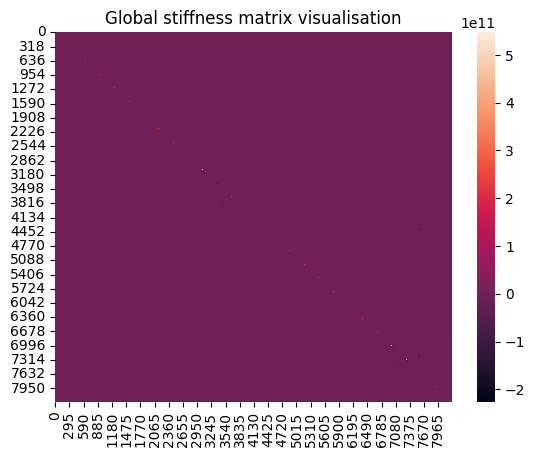

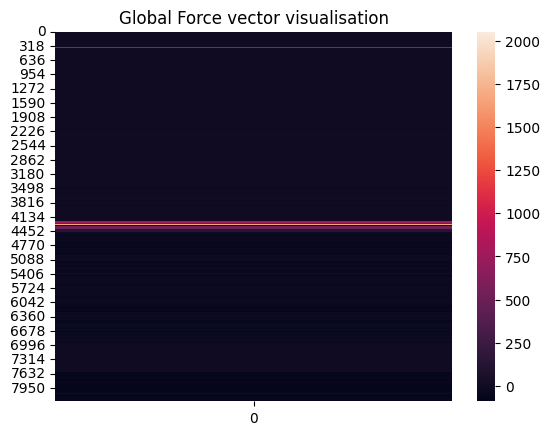

In [46]:
nodesn = len(node_coords)  # defines number of all nodes to be usesd as global in CST_mechanical

K = np.zeros((2 * len(node_coords), 2 * len(node_coords)))
print(f'K shape: {K.shape}')  # shape of global K
F = np.zeros((2 * len(node_coords), 1))
print(f'F shape: {F.shape}')

E = [68e9, 160e9, 85e9]  # Young moduli of aluminum, silicon and glass [Pa] (average values)
nu = [0.33, 0.27, 0.2]  # Poissons ratios for aluminum, silicon and glass [-] (average values)
alpha = [23e-6, 2.5e-6, 6.7e-7]  # Thermal expansion coefficient for aluminum, silicon and glass [K-1] ()

for s, surface in enumerate(surfaces):  # surfaces is list of 3 defined surfaces
  #print(f'Surface no: {s + 1}')
  for ss, element in enumerate(surface):  # surface is list consisting of elements defined by their node numbers [15 107 42]
    #print(f'Element no: {ss + 1} : {element}')
    K, F = CST_mechanical(K, F, element, E[s], nu[s], alpha[s])


sns.heatmap(K, annot=False, cmap='rocket')
plt.title('Global stiffness matrix visualisation')
plt.show()
sns.heatmap(F, annot=False, cmap='rocket')
plt.title('Global Force vector visualisation')
plt.show()

In [47]:
u_disp = np.linalg.solve(K, F)
print(u_disp.shape)

(8250, 1)


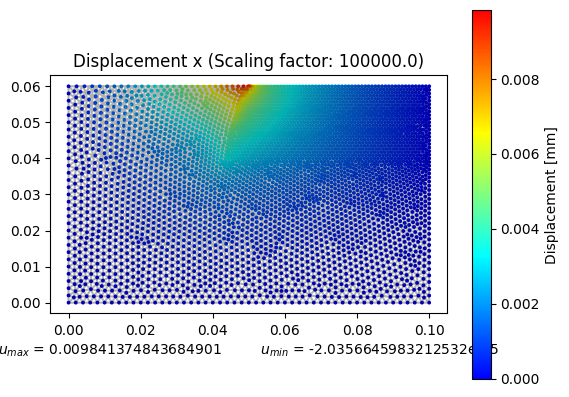

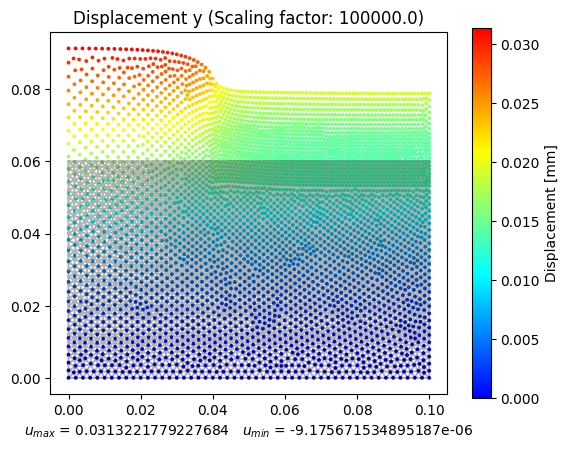

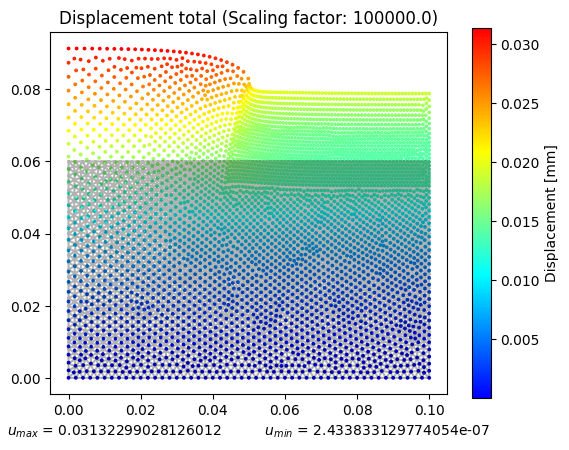

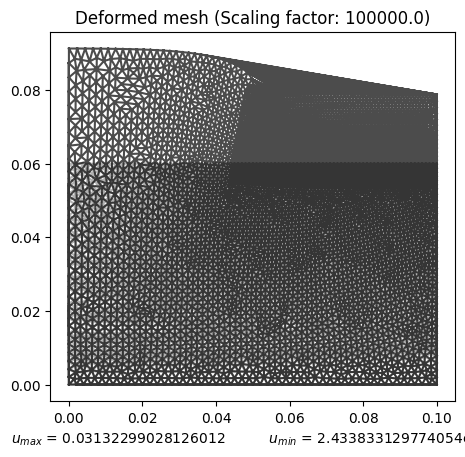

In [48]:
x = node_coords[:, 0]
y = node_coords[:, 1]

colors = ['blue','cyan', 'yellow', 'red']  # define colorbar colors
cmap1 = LinearSegmentedColormap.from_list('blue_to_red', colors)  # create colormap

sf = 1e5  # scaling factor

ux = sf * u_disp[:nodesn, 0]  # separate displacement in x direction
uy = sf * u_disp[nodesn:2*nodesn, 0]  # separate disp in y direction
u_total = np.array(np.sqrt(ux**2 + uy**2))  # calculate total displacement

# ux
plt.scatter(x + ux, y, c=ux, s=3, cmap=cmap1)  # plot the nodes in deformed x place

plt.triplot(x, y, alpha=0.3, color='k')  # underlaying mesh
plt.gca().set_aspect('equal')

plt.colorbar(label='Displacement [mm]')
plt.title(f'Displacement x (Scaling factor: {sf})')
plt.xlabel('$u_{max}$ = ' + str(max(ux)) + ' \t $u_{min}$ = ' + str(min(ux)) )
plt.show()

# uy
plt.scatter(x, y + uy, c=uy, s=3, cmap=cmap1)

plt.triplot(x, y, alpha=0.3, color='k')  # underlaying mesh
plt.gca().set_aspect('equal')

plt.colorbar(label='Displacement [mm]')
plt.title(f'Displacement y (Scaling factor: {sf})')
plt.xlabel('$u_{max}$ = ' + str(max(uy)) + ' \t $u_{min}$ = ' + str(min(uy)) )
plt.show()

# u total
plt.scatter(x + ux, y + uy, c=u_total, s=3, cmap=cmap1)

plt.triplot(x, y, alpha=0.3, color='k')  # underlaying mesh
plt.gca().set_aspect('equal')

plt.colorbar(label='Displacement [mm]')
plt.title(f'Displacement total (Scaling factor: {sf})')
plt.xlabel('$u_{max}$ = ' + str(max(u_total)) + ' \t $u_{min}$ = ' + str(min(u_total)) )
plt.show()

# u total deformed mesh

plt.triplot(x + ux, y + uy, alpha=0.7, color='k')  # deformed mesh
plt.triplot(x, y, alpha=0.3, color='k')  # underlaying mesh
plt.gca().set_aspect('equal')

plt.title(f'Deformed mesh (Scaling factor: {sf})')
plt.xlabel('$u_{max}$ = ' + str(max(u_total)) + ' \t $u_{min}$ = ' + str(min(u_total)) )
plt.show()

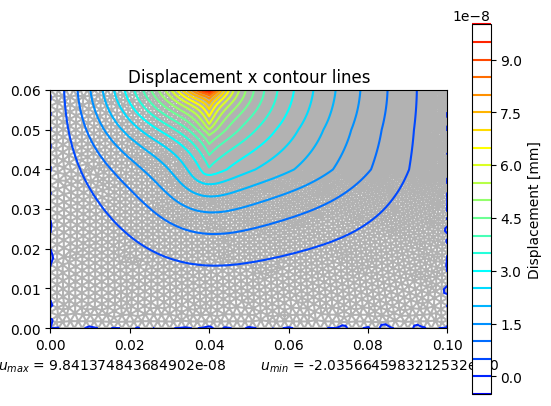

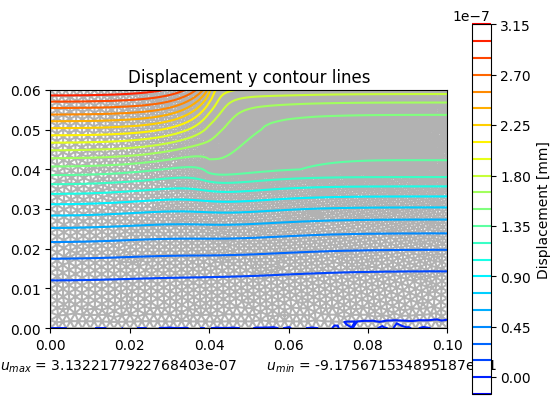

In [49]:
triang = Triangulation(x, y)

# Create a contour plot ux
plt.tricontour(triang, u_disp[:nodesn, 0], levels=20, cmap=cmap1)
plt.colorbar(label='Displacement [mm]')

plt.triplot(x, y, alpha=0.3, color='k')  # underlying mesh
plt.gca().set_aspect('equal')

plt.title('Displacement x contour lines')
plt.xlabel('$u_{max}$ = ' + str(max(u_disp[:nodesn, 0])) + ' \t $u_{min}$ = ' + str(min(u_disp[:nodesn, 0])) )
plt.show()

# uy
plt.tricontour(triang, u_disp[nodesn:2*nodesn, 0], levels=20, cmap=cmap1)
plt.colorbar(label='Displacement [mm]')

plt.triplot(x, y, alpha=0.3, color='k')  # underlying mesh
plt.gca().set_aspect('equal')

plt.title('Displacement y contour lines')
plt.xlabel('$u_{max}$ = ' + str(max(u_disp[nodesn:2*nodesn, 0])) + ' \t $u_{min}$ = ' + str(min(u_disp[nodesn:2*nodesn, 0])) )
plt.show()


### =========================================================================================
### Unsure about the heat flux

In [ ]:
'''
def element_flux(Q, element):
  global u

  B_matrix = B(element)  # calculate B of element

  T = np.zeros((3,1))  # initate temperature vector of the nodes

  for i, node in enumerate(element):
    T[i] = u[int(node) - 1]  # get the nodal temperatures of the element

  q = np.dot(B_matrix, T)  # compute elemental q
  #print(q.shape)
  #print(f'q: \n {type(q)}')
  Q = np.append(Q, q, axis=1)  # append the small q to the big Q

  return Q
'''

In [ ]:
'''
Q = np.array([[], []])

for s, surface in enumerate(surfaces):  # surfaces is list of 3 defined surfaces
  #print(f'Surface no: {s + 1}')
  for ss, element in enumerate(surface):  # surface is list consisting of elements defined by their node numbers [15 107 42]
    #print(f'Element no: {ss + 1} : {element}')
    Q = element_flux(Q, element)

'''

"\nQ = np.array([[], []])\n\nfor s, surface in enumerate(surfaces):  # surfaces is list of 3 defined surfaces\n  #print(f'Surface no: {s + 1}')\n  for ss, element in enumerate(surface):  # surface is list consisting of elements defined by their node numbers [15 107 42]\n    #print(f'Element no: {ss + 1} : {element}')\n    Q = element_flux(Q, element)\n\n"

In [ ]:
'''
# Your triangulation
x = node_coords[:, 0]
y = node_coords[:, 1]
triang = tri.Triangulation(x, y)

# Your data (could be values corresponding to the vertices)
qx = Q[0, :].astype(float)
qy = Q[1, :].astype(float)


# plt.triplot(triang, 'k-')  # Plot the mesh without coloring

triangles = plt.tripcolor(triang, qx, shading='flat', cmap=cmap1)
plt.gca().set_aspect('equal')
plt.colorbar(triangles, label='[W m$^{-1}$] ?')
plt.title('Heat flux Qx')
plt.show()

triangles = plt.tripcolor(triang, qy, shading='flat', cmap=cmap1)
plt.gca().set_aspect('equal')
plt.colorbar(triangles, label='[W m$^{-1}$] ?')
plt.title('Heat flux Qy')
plt.show()

'''


"\n# Your triangulation\nx = node_coords[:, 0]\ny = node_coords[:, 1]\ntriang = tri.Triangulation(x, y)\n\n# Your data (could be values corresponding to the vertices)\nqx = Q[0, :].astype(float)\nqy = Q[1, :].astype(float)\n\n\n# plt.triplot(triang, 'k-')  # Plot the mesh without coloring\n\ntriangles = plt.tripcolor(triang, qx, shading='flat', cmap=cmap1)\nplt.gca().set_aspect('equal')\nplt.colorbar(triangles, label='[W m$^{-1}$] ?')\nplt.title('Heat flux Qx')\nplt.show()\n\ntriangles = plt.tripcolor(triang, qy, shading='flat', cmap=cmap1)\nplt.gca().set_aspect('equal')\nplt.colorbar(triangles, label='[W m$^{-1}$] ?')\nplt.title('Heat flux Qy')\nplt.show()\n\n"

#Mechanical Part

In [ ]:
# CST function change
# ke matrix 6x6 (3 elements, 2 dof)
# re vector 6x1
# ke = int_V B_T C B dV (C elasticity tensor)
# re = B_T sigma [3x1]
# sigma = sigma 11, sigma 22, sigma 12 - plane strain (sigma33 non zero, can be computed afterwards)
# young modulus and poisson ratio, temperature


#Code Graveyard

where code that should not be ran goes...